In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gp
from geopandas import GeoDataFrame
from shapely.geometry import LineString
from shapely.geometry import MultiPoint
from shapely.geometry import Point
import shapely
import networkx as nx
import os.path
from os import path
import pathlib
import pandas as pd
from datetime import datetime
import numpy as np

import geopy.distance


from OSMPythonTools.api import Api as osm_api
ox.config(log_console=True, use_cache=True)

In [2]:
# Isochrone Maxspeed

start_point = (52.5153, 13.4040)
hours_of_day = range(24)
speed_aggregate = 'mean' # min, mean, max
local_set = True
path = 'travel_time+uberJan2020.graphml'

In [3]:
#G = ox.graph.graph_from_point(start_point, dist=dist, dist_type='network', network_type='drive')
#, simplify=True, retain_all=False, truncate_by_edge=False, clean_periphery=True, custom_filter=None)


In [4]:
if local_set:
    G = ox.graph.graph_from_place('Berlin, Germany', retain_all=True, buffer_dist=2500, network_type='drive', simplify=False)
    speed_df_orig = pd.read_csv('../data/Uber_speeds/movement-speeds-hourly-berlin-2020-1.csv')
else:
    G = ox.io.load_graphml(path)#, node_type=None, node_dtypes=None, edge_dtypes=None)
    

In [5]:
# Load Uber speeds into osm Graph

if speed_aggregate == 'min':
    speed_df = speed_df_orig.groupby(['osm_way_id','osm_start_node_id','osm_end_node_id']).min()['speed_kph_mean'].reset_index()
elif speed_aggregate == 'mean':
    speed_df = speed_df_orig.groupby(['osm_way_id','osm_start_node_id','osm_end_node_id']).mean()['speed_kph_mean'].reset_index()
elif speed_aggregate == 'max':
    speed_df = speed_df_orig.groupby(['osm_way_id','osm_start_node_id','osm_end_node_id']).max()['speed_kph_mean'].reset_index()

    
for way in speed_df.iloc():
    node_ids = [int(way['osm_start_node_id']),int(way['osm_end_node_id'])]
    try:
        G.edges[min(node_ids),max(node_ids),0]['real_speed'] = way['speed_kph_mean']
    except:
        pass


In [6]:
# Calculate Way Times for each Segment

for u, v, k, data in G.edges(data=True, keys=True):
    #print('maxspeed' in data.keys())
    if ('maxspeed' in data.keys()):
        #print(isinstance(data['maxspeed'], list))
        #print(data['maxspeed'])
        #print(type(data['maxspeed']))
        if(isinstance(data['maxspeed'], list)):
            
            
            #print(type(data['maxspeed']))
            #print(data['maxspeed'])
            speed = min(data['maxspeed'])
            #print(speed)
        else:
            speed = data['maxspeed']
    else:
        speed = 50.0
        
    if (speed == 'DE:urban'):
        speed = 50.0
    elif (speed == 'walk'):
        speed = 6.0
    elif (speed == 'none'):
        speed = 130.0
        
    #print(speed)    
    data['time'] = data['length'] / (float(speed) * 1000 / 60)
    data['maxspeed'] = float(speed)
    #print(data['test_maxspeed'])

    
    
    if ('real_speed' in data.keys()):
        real_speed = float(data['real_speed'])
    else:
        real_speed = speed
    data['real_time'] = data['length'] / (float(real_speed)* 1000 / 60)

ox.save_graphml(G, filepath='./travel_time+uberJan2020.graphml')

In [7]:
#nodes, edges = ox.graph_to_gdfs(G)
#set(list(edges['maxspeed'].values))

In [8]:
#center_node = ox.get_nearest_node(G, start_point)

#subgraph_15 = nx.ego_graph(G, center_node, radius=5, distance='time')
#subgraph_15_real = nx.ego_graph(G, center_node, radius=5, distance='real_time')

#ox.plot_graph(subgraph_15)
#ox.plot_graph(subgraph_15_real)



In [9]:
#nodes, edges = ox.graph_to_gdfs(subgraph_15_real)

#lat, long = MultiPoint(nodes.reset_index()['geometry']).convex_hull.exterior.coords.xy

#nodes['geometry'].plot()
#zip(lat,long)[0]

#MultiPoint(nodes.reset_index()['geometry']).convex_hull
    
#dist = [geopy.distance.geodesic(point,start_point).meters for point in zip(long,lat)]
#np.mean(dist)

In [10]:
#nodes, edges = ox.graph_to_gdfs()
#edges = edges.sort_values('time')
#nodes

In [11]:
def getAvgIsochroneDistStreet(start_point, travel_time_min, real_speed=True, plot_subgraph=False):
    x, y = Point(start_point).xy
    center_node = ox.get_nearest_node(G, (y[0],x[0]))
    dist=[]
    distance_type = 'real_time' if real_speed else 'time'
    
    subgraph = nx.ego_graph(G, center_node, radius=travel_time_min, distance=distance_type)
    
    dist = []
    if plot_subgraph:
        ox.plot_graph(subgraph)
    nodes, edges = ox.graph_to_gdfs(subgraph)
    lat, long = MultiPoint(nodes.reset_index()['geometry']).convex_hull.exterior.coords.xy
    #dist = []
    
    for point in zip(lat,long):
        try:
            dist.append(geopy.distance.geodesic(point,start_point).meters)
        except:
            dist.append(float(0.0))
    
    return np.mean(dist)
                            

In [12]:
#getAvgIsochroneDistStreet((52.617670, 13.223318), 5)
getAvgIsochroneDistStreet((13.223318, 52.617670), 5)

2910.7369366390253

In [162]:
def getAvgIsochroneDistStreet_list(list_of_points, travel_time_min):
    list_of_avg = []
    for point in list_of_points:
        try:
            list_of_avg.append(getAvgIsochroneDistStreet(point, travel_time_min, real_speed=True, plot_subgraph=False))
        except:
            list_of_avg.append(float(0.0))
    return list_of_avg
    #return [getAvgIsochroneDistStreet(point, travel_time_min, real_speed=True, plot_subgraph=False) for point in list_of_points ]

In [163]:
list_of_points = [(13.3355015, 52.5652055),
 (13.3466053, 52.567033),
 (13.3522545, 52.567738),
 (13.339564, 52.5640768),
 (13.3429006, 52.5633975),
 (13.3373679, 52.5587807),
 (13.3306441, 52.5626152),
 (13.3277078, 52.5640457),
 (13.3202135, 52.5659103),
 (13.3460089, 52.5746796),
 (13.3521078, 52.573666),
 (13.223318, 52.617670)]

In [164]:
list_of_points

[(13.3355015, 52.5652055),
 (13.3466053, 52.567033),
 (13.3522545, 52.567738),
 (13.339564, 52.5640768),
 (13.3429006, 52.5633975),
 (13.3373679, 52.5587807),
 (13.3306441, 52.5626152),
 (13.3277078, 52.5640457),
 (13.3202135, 52.5659103),
 (13.3460089, 52.5746796),
 (13.3521078, 52.573666),
 (13.223318, 52.61767)]

In [165]:
type(list_of_points)

list

In [166]:
type(list_of_points[0])

tuple

In [167]:
getAvgIsochroneDistStreet_list(list_of_points, 1)

[966.3989078822983,
 893.7996979168427,
 775.1927108393782,
 549.3071439668252,
 802.4380705938473,
 779.0320054908456,
 923.2139286447663,
 846.7789439417503,
 836.629831889678,
 871.7162721339846,
 960.6990439838968,
 248.1645827665362]

#  AvgIsoDistance of a PointList

<AxesSubplot:>

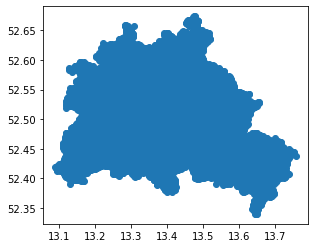

In [168]:
samplepoints = gp.read_file("../results/sample-points.geojson")
samplepoints.plot()

In [169]:
samplepoints

,geometry
0,POINT (13.62497 52.44779)
1,POINT (13.40690 52.63923)
2,POINT (13.49900 52.53596)
3,POINT (13.34730 52.45579)
4,POINT (13.22939 52.52717)
...,...
9995,POINT (13.62245 52.46234)
9996,POINT (13.42021 52.41784)
9997,POINT (13.37158 52.43085)
9998,POINT (13.40282 52.48666)


In [170]:
geodf = gp.read_file("../results/isochrones-drive-15.geojson")


In [171]:
#samplepoints.geometry.tolist()

In [172]:
samplepoints = gp.read_file("../results/sample-points.csv")

C:\Users\micha\anaconda3\envs\geo\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [173]:
samplepoints = samplepoints[['field_1', 'field_2']]
samplepoints

,field_1,field_2
0,13.624967263168204,52.44778640358857
1,13.406899879057638,52.63922539580549
2,13.499001025640009,52.53595778596054
3,13.347295538251013,52.45579154543654
4,13.229388389684887,52.52717318858545
...,...,...
9995,13.622453158346584,52.46234116705562
9996,13.420209764147899,52.41784199277333
9997,13.371575489737966,52.4308462651603
9998,13.402821579569277,52.48665864951218


In [174]:
samplepoints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   field_1  10000 non-null  object
 1   field_2  10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [175]:
# changing the dataframe  
# data types to string 
samplepoints = samplepoints.astype(float) 
  
# show the data types  
# of dataframe 
samplepoints.dtypes

field_1    float64
field_2    float64
dtype: object

In [176]:
samplepoints = samplepoints.apply(tuple, axis=1)


In [177]:
samplepoints = samplepoints.tolist()

In [178]:
samplepoints[0:5]

[(13.624967263168204, 52.44778640358857),
 (13.406899879057638, 52.63922539580549),
 (13.499001025640009, 52.53595778596054),
 (13.347295538251013, 52.45579154543654),
 (13.229388389684887, 52.52717318858545)]

In [179]:
#geodf = geodf.apply(tuple, axis=1)

In [180]:
#df = pd.read_json("../results/sample-points.geojson")
#print("len ("+str(len(df))+")")
#df.head(5)

In [181]:
#geodf = gp.GeoDataFrame(samplepoints)
#print("len ("+str(len(geodf))+")")
#geodf.head(5)

In [182]:
#geodf = gp.GeoDataFrame(geodf)
#geodf.rename(columns = {0:'geometry'}, inplace = True) 
#geodf

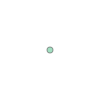

In [183]:
geodf.geometry[1]

In [184]:
#print(f'NumPy Array:\n{arr}')
#list1 = geodf.values().toList()
#list1=[]
#for i in range(len(geodf)):
#    list1.append(geodf.geometry[i])


In [185]:
list1 = samplepoints

# Fixed

# 5 Minute Calculation

In [153]:
avg_iso_list = getAvgIsochroneDistStreet_list(list1,5)
#Haesslicher Fehler ???
#avg_iso_list = getAvgIsochroneDistStreet_list(list1[182:199], 5)

(13.624967263168204, 52.44778640358857)
<class 'tuple'>
### APPEND DISTANZ ###
(13.406899879057638, 52.63922539580549)
<class 'tuple'>
### APPEND DISTANZ ###
(13.499001025640009, 52.53595778596054)
<class 'tuple'>
### APPEND DISTANZ ###
(13.347295538251013, 52.45579154543654)
<class 'tuple'>
### APPEND DISTANZ ###
(13.229388389684887, 52.52717318858545)
<class 'tuple'>
### APPEND DISTANZ ###
(13.268897510682791, 52.435315398585914)
<class 'tuple'>
### APPEND DISTANZ ###
(13.59077001901181, 52.40856874605705)
<class 'tuple'>
### APPEND DISTANZ ###
(13.367633664171064, 52.51166050645527)
<class 'tuple'>
### APPEND DISTANZ ###
(13.570052910847426, 52.566883205526786)
<class 'tuple'>
### APPEND DISTANZ ###
(13.388136011863443, 52.406966365406674)
<class 'tuple'>
### APPEND DISTANZ ###


In [60]:
avg_iso_list[0:10]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [157]:
geodf["avg_dist"] = avg_iso_list

NameError: name 'geodf' is not defined

In [ ]:
geodf["geometry"] = Point()

In [ ]:
for i in range(len(geodf)):
    geodf.geometry[i] = Point(geodf.lon[i],geodf.lat[i],)

In [ ]:
del geodf["lon"]

In [ ]:
del geodf["lat"]

In [ ]:
geodf = geodf[['geometry','avg_dist']]

In [ ]:
geodf

In [ ]:
geodf.to_file("../results/isochrones-drive-5.geojson", driver='GeoJSON')

# 10 Minute Calculation

In [ ]:
avg_iso_list = getAvgIsochroneDistStreet_list(list1, 10)
geodf["avg_dist"] = avg_iso_list
geodf.to_file("../results/isochrones-drive-10.geojson", driver='GeoJSON')

# 15 Minute Calculation

In [ ]:
avg_iso_list = getAvgIsochroneDistStreet_list(list1, 15)
geodf["avg_dist"] = avg_iso_list
geodf.to_file("../results/isochrones-drive-15.geojson", driver='GeoJSON')

# 20 Minutes Calculation

In [ ]:
geodf = gp.read_file("../results/isochrones-drive-15.geojson")
avg_iso_list = getAvgIsochroneDistStreet_list(list1, 20)
geodf["avg_dist"] = avg_iso_list


In [161]:
avg_iso_list[0:100]

[31359.76148149969, 30267.012743275332]

In [ ]:
geodf.to_file("../results/isochrones-drive-40.geojson", driver='GeoJSON')